# **Burger's equation**:
# $ u_t + u u_{xx} = v u_{xx} \qquad x\in[-1,1], \quad t\in [0,1], \quad u ≡ u(x,t)$

## Boundary conditions (Dirichlet):
* $ u(-1, t) = 0, \qquad t\in [0,1]$
* $ u(1, t) = 0, \qquad t\in [0,1]$

## Initial condition:
* $ u(x, 0) = -\sin(\pi x), \qquad x\in[-1,1] $

<!-- ## *ANALYTICAL SOLUTION*
## $ u(x, y, t) = e^{-13\pi^2t}\sin(3\pi x)\sin(2\pi y)  $ -->




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from scipy.stats import qmc

import warnings
warnings.filterwarnings("ignore")

# Helpers

## Data

In [40]:
def generate_random_numbers(min_, max_, N, dtype):
    return min_ + (max_ - min_) * torch.rand(size=(N,), dtype=dtype)


class Data():
    def __init__(self,
                 x_min, x_max,
                 t_min, t_max,
                 Nx_init, Nt_bound,
                 device='cpu',
                 dtype=torch.float32):

        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.Nx_init = Nx_init
        self.Nt_bound = Nt_bound
        self.device = device
        self.dtype = dtype


    # *** Create in-domain points ***
    def sample_domain(self, Nx_domain, Nt_domain, x_min, x_max, t_min, t_max):
        # Random Grid
        x_domain = generate_random_numbers(x_min, x_max, Nx_domain, dtype)
        t_domain = generate_random_numbers(t_min, t_max, Nt_domain, dtype)
        domain_data = torch.stack((x_domain, t_domain), dim=1)
        return torch.tensor(domain_data, dtype=self.dtype, device=self.device, requires_grad=True)

    # *** Boundary Conditions ***
    def sample_boundary(self):
        # Random boundary points
        t_bound = generate_random_numbers(self.t_min, self.t_max, self.Nt_bound, self.dtype)
        x_left = - torch.ones(1, dtype=self.dtype)
        x_right = torch.ones(1, dtype=self.dtype)

        bound_data_left = torch.stack(torch.meshgrid(x_left, t_bound)).view(2, -1).permute(1, 0)
        bound_data_right = torch.stack(torch.meshgrid(x_right, t_bound)).view(2, -1).permute(1, 0)
        bound_data = torch.cat([bound_data_left, bound_data_right]).requires_grad_(True).to(self.device)

        u_bound = torch.zeros(len(bound_data), 1, dtype=self.dtype, device=self.device)

        return bound_data, u_bound


    # *** Initial Condition ***
    def sample_initial(self):
        # Random initial points
        x_init = generate_random_numbers(self.x_min, self.x_max, self.Nx_init, self.dtype)
        t_init = torch.zeros(1, dtype=self.dtype)
        init_data = torch.stack(torch.meshgrid(x_init, t_init)).view(2, -1).permute(1, 0).requires_grad_(True).to(self.device)

        u_init = - torch.sin(math.pi * x_init).to(self.device)

        return init_data, u_init

    # *** Test set ***
    def sample_test(self):
        test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv').dropna().to_numpy()
        return torch.tensor(test_data, dtype=self.dtype, device=self.device, requires_grad=True)
        # x_test = self.x_min + (self.x_max - self.x_min) * torch.rand(self.N_test)
        # t_test = self.t_min + (self.t_max - self.t_min) * torch.rand(self.N_test)
        # return torch.stack([x_test, t_test], dim=1).requires_grad_(True).to(self.device)

## Network

In [41]:
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.Tanh(), weight_init=None, bias_init=None, device='cpu'):
        super().__init__()
        self.n_layers = len(layers) - 1
        self.layers = layers
        self.activation = activation
        self.weight_init = weight_init
        self.bias_init = bias_init

        dense_layers = [
            self.dense_layer(in_features=self.layers[i], out_features=self.layers[i + 1])
            for i in range(self.n_layers - 1)]
        dense_layers.append(nn.Linear(in_features=self.layers[-2], out_features=self.layers[-1]))

        self.mlp = nn.Sequential(*dense_layers).to(device)

    def dense_layer(self, in_features, out_features):
        dense_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
        )

        if self.weight_init is not None:
            self.weight_init(dense_layer[0].weight)

        if self.bias_init is not None:
            self.bias_init(dense_layer[0].bias)

        dense_layer.add_module("activation", self.activation)
        return dense_layer

    def forward(self, x):
        return self.mlp(x)

## PINN-Base

In [42]:
class PINNBase():
    def __init__(self,
                 layers,
                 activation,
                 device):

        self.v = 0.01 / math.pi

        # Define the model
        self.model = MLP(layers=layers,
                         activation=activation,
                         weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                         bias_init=lambda m: nn.init.zeros_(m.data),
                         device=device)

        # Set the optimizers
        adam = torch.optim.Adam(self.model.parameters())
        lbfgs = torch.optim.LBFGS(self.model.parameters(),
                                  lr=1,
                                  max_iter=2_000,
                                  max_eval=None,
                                  tolerance_grad=1e-07,
                                  tolerance_change=1e-09,
                                  history_size=100,
                                  line_search_fn='strong_wolfe')

        self.optimizers = {"adam": adam, "lbfgs": lbfgs}

        # Set the Loss function
        self.criterion = nn.MSELoss()

        # Set the MAE criterion for test data only
        self.l1_loss = nn.L1Loss()


    def forward(self, x):
        return self.model(x)


    def grad(self, output, input):
        return torch.autograd.grad(
                    output, input,
                    grad_outputs=torch.ones_like(output),
                    retain_graph=True,
                    create_graph=True
                )[0]


    def calculate_pde_residual(self, x):
        # Forward pass
        u = self.forward(x)

        # Calculate 1st and 2nd derivatives
        du_dX = self.grad(u, x)
        du_dXX = self.grad(du_dX, x)

        # Retrieve the partial gradients
        du_dt = du_dX[:, 1].flatten()
        du_dx = du_dX[:, 0].flatten()
        du_dxx = du_dXX[:, 0].flatten()

        return du_dt + u.flatten() * du_dx - self.v * du_dxx


    def calculate_pde_loss(self, data):
        # Calculate the domain loss
        self.pde_res = self.calculate_pde_residual(data)
        pde_target = torch.zeros_like(self.pde_res)
        return self.criterion(self.pde_res, pde_target)


    def calculate_total_loss(self, data):
        # Calculate boundary loss
        loss_b = self.criterion(
            self.forward(data["bound_data"]).flatten(),
            data["u_bound"].flatten()
        )

        # Calculate initial loss
        loss_i = self.criterion(
            self.forward(data["init_data"]).flatten(),
            data["u_init"].flatten()
        )

        # Calculate the domain loss
        loss_pde = self.calculate_pde_loss(data["domain_data"])

        # Calculate total discriminator loss
        return loss_b + loss_i + loss_pde


    def calculate_test_loss(self, test_data):
        pde_res = self.calculate_pde_residual(test_data)
        pde_target = torch.zeros_like(pde_res)
        return self.l1_loss(pde_res, pde_target)


    def train_step(self, data):
        loss = self.calculate_total_loss(data)
        loss.backward()
        return loss


    def closure(self):
        self.lbfgs_optimizer.zero_grad()
        return self.train_step(self.data)

## PINN

In [43]:
class PINN():
    def __init__(self,
                 x_min, x_max,
                 t_min, t_max,
                 Nx_domain,
                 Nt_domain,
                 Nx_init,
                 Nt_bound,
                 Nx_domain_resample,
                 Nt_domain_resample,
                 max_domain_points,
                 N_top_errors,
                 N_top_errors_increase,
                 N_bound_increase,
                 N_init_increase,
                 layers,
                 activation,
                 checkpoint_path,
                 device='cpu',
                 dtype=torch.float32):

        # Constants
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.dtype = dtype
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.Nx_domain = Nx_domain
        self.Nt_domain = Nt_domain
        self.Nx_init = Nx_init
        self.Nt_bound = Nt_bound
        self.Nx_domain_resample = Nx_domain_resample
        self.Nt_domain_resample = Nt_domain_resample
        self.max_domain_points = max_domain_points
        self.N_top_errors = N_top_errors
        self.N_top_errors_increase = N_top_errors_increase
        self.N_bound_increase = N_bound_increase
        self.N_init_increase = N_init_increase

        # Create real data
        self.data_init = Data(x_min, x_max,
                              t_min, t_max,
                              Nx_init,
                              Nt_bound,
                              device,
                              dtype)

        # Create test data
        self.test_data = self.data_init.sample_test()

        # Create base PINN
        self.base_pinn = PINNBase(layers, activation, device)


    def generate_data(self):
        # Create real data
        data = {}
        data["domain_data"] = self.data_init.sample_domain(self.Nx_domain,
                                                           self.Nt_domain,
                                                           self.x_min,
                                                           self.x_max,
                                                           self.t_min,
                                                           self.t_max)
        data["bound_data"], data["u_bound"] = self.data_init.sample_boundary()
        data["init_data"], data["u_init"] = self.data_init.sample_initial()
        return data


    def train_with_adam(self, N_adam, data):
        optimizer = self.base_pinn.optimizers['adam']
        loss = None

        for epoch in range(1, N_adam + 1):
            optimizer.zero_grad()
            loss = self.base_pinn.train_step(data)
            optimizer.step()

        return loss


    def train_with_lbfgs(self, N_lbfgs, data):
        self.base_pinn.lbfgs_optimizer = self.base_pinn.optimizers["lbfgs"]
        self.base_pinn.data = data

        for epoch in range(1, N_lbfgs + 1):
            loss = self.base_pinn.lbfgs_optimizer.step(self.base_pinn.closure)

        return loss


    def checkpoint(self):
        torch.save({
            "model": self.base_pinn.model.state_dict()
        }, self.checkpoint_path)


    def format_loss(self, loss):
        if loss == 0:
            return "0.0e+00"

        # Calculate the exponent part
        exponent = int(math.log10(abs(loss)))

        # Determine the format based on the value of the loss
        if abs(loss) < 1:
            formatted_loss = f"{loss:.2e}"
        else:
            # Adjust the sign of the formatted loss
            sign = "-" if loss < 0 else ""

            # Calculate the number of decimal places
            decimal_places = 2 - exponent

            # Ensure at least two decimal places
            decimal_places = max(decimal_places, 2)

            # Format the loss with the correct sign
            formatted_loss = f"{sign}{abs(loss):.{decimal_places}e}"

        return formatted_loss


    def keep_checkpoints_and_print_losses(self, iter, patience, print_every, loss, loss_test):

        loss_str = self.format_loss(loss)
        loss_test_str = self.format_loss(loss_test)

        if iter == 1:
            self.best_val_loss = loss_test
            self.best_epoch = -1
            self.checkpoint()
            self.flag = 1
            print(f"Iteration: {iter} | loss: {loss_str} | test_mae: {loss_test_str} - *Checkpoint*")
        else:
            if loss_test < self.best_val_loss:
                self.best_val_loss = loss_test
                self.best_epoch = iter
                self.checkpoint()
                self.flag = 1
                if iter % print_every == 0:
                    print(f"Iteration: {iter} | loss: {loss_str} | test_mae: {loss_test_str} - *Checkpoint*")
            elif iter - self.best_epoch > patience:
                if iter % print_every == 0:
                    self.early_stopping_applied = 1
                    print(f"Iteration: {iter} | loss: {loss_str} | test_mae: {loss_test_str}")
                return

        if (self.flag == 0) and (iter % print_every == 0):
            print(f"Iteration: {iter} | loss: {loss_str} | test_mae: {loss_test_str}")


    def define_rectangle(self, results_df):
        # Sort DataFrame by the absolute PDE-errors and keep 'N_top_errors'
        results_df.sort_values(by='pde_res', ascending=False, inplace=True)
        top_errors_df = results_df.head(self.N_top_errors)

        # Extract the rectangle with the greatest test errors
        x_min, x_max = top_errors_df['x_train'].min(), top_errors_df['x_train'].max()
        t_min, t_max = top_errors_df['t_train'].min(), top_errors_df['t_train'].max()

        return x_min, x_max, t_min, t_max


    def create_valid_rectangle(self, results_df, x_min, x_max, t_min, t_max):

        while x_min == x_max:
            # x_min = x_max = -1 or 1
            if (x_max == self.x_min) or (x_min == self.x_max):
                self.Nt_bound += self.N_bound_increase
                self.data["bound_data"], self.data["u_bound"] = self.data_init.sample_boundary(self.Nt_bound)

            # x_min = x_max = x
            else:
                # Increase self.N_top_errors and resample
                self.N_top_errors += self.N_top_errors_increase

                # Define the rectangle where to oversample
                x_min, x_max, t_min, t_max = self.define_rectangle(results_df)

        while t_min == t_max:
            # t_min = t_max = 0
            if t_max == self.t_min:
                # Sample more on the left boundary
                self.Nx_init += self.N_init_increase

                # Be careful !! --> Sample with 'x_min' and 'x_max'
                # (derived from above) NOT with 'self.x_min' and 'self.x_max'
                self.data["init_data"], self.data["u_init"] = self.data_init.sample_initial(self.Nx_init, x_min, x_max)

            # t_min = t_max = t
            else:
                # Increase self.N_top_errors and resample
                self.N_top_errors += self.N_top_errors_increase

                # Define the rectangle where to oversample
                x_min, x_max, t_min, t_max = self.define_rectangle(results_df)

        return x_min, x_max, t_min, t_max


    def train(self, iters, patience, print_every, N_adam, N_lbfgs):
        print(f"PINN: {iters} iterations")
        print(f"a. PINN: {N_adam} epochs --> Adam")
        print(f"b. PINN: {N_lbfgs} epochs --> L-BFGS")

        for iter in tqdm(range(1, iters + 1)):
            self.flag = 0
            self.early_stopping_applied = 0

            data = self.generate_data()

            if iter == 1:
                self.data = data
            else:
                if self.data["domain_data"].shape[0] <= self.max_domain_points:
                    pde_res = self.base_pinn.pde_res

                    # Create DataFrame with cols: 'x_test', 't_test' and 'val_pde_residual'
                    data_copy = self.data["domain_data"].clone().detach().cpu().numpy()
                    pde_abs_errors = np.abs(pde_res.clone().detach().cpu().numpy()).reshape(-1, 1)
                    results = np.concatenate((data_copy, pde_abs_errors), axis=1)
                    results_df = pd.DataFrame(results, columns=['x_train', 't_train', 'pde_res'])

                    # Define the rectangle where to oversample
                    x_min, x_max, t_min, t_max = self.define_rectangle(results_df)

                    # After calling 'create_valid_rectangle' t's are valid, but x's have changed anew. Therefore
                    # I have to call the same function until a valid rectangle is created to be oversampled.
                    while x_min == x_max:
                        x_min, x_max, t_min, t_max = self.create_valid_rectangle(results_df, x_min, x_max, t_min, t_max)

                    # Sample new training collocation points in this rectangle
                    domain_data_new = self.data_init.sample_domain(self.Nx_domain_resample,
                                                                   self.Nt_domain_resample,
                                                                   x_min, x_max, t_min, t_max)
                    domain_data_new_pr = domain_data_new.clone() if iter == 2 else torch.cat((domain_data_new, domain_data_new_pr), dim=0)

                # Append the new points to the already existing
                self.data["domain_data"] = torch.cat((data["domain_data"], domain_data_new_pr), dim=0)


            loss = self.train_with_adam(N_adam, self.data)

            loss = self.train_with_lbfgs(N_lbfgs, self.data)
            loss_test = self.base_pinn.calculate_test_loss(self.test_data)

            self.keep_checkpoints_and_print_losses(iter, patience, print_every, loss, loss_test)

            if self.early_stopping_applied:
                print(f"\nEarly stopping applied at epoch {iter}.")
                break

# Main

In [44]:
# Data
x_min, x_max = -1, 1
t_min, t_max = 0, 1
N_domain = 1_500
Nx_domain = N_domain
Nt_domain = N_domain
Nx_init = 100
Nt_bound = 100
N_test = 100_000

N_domain_resample = 100
Nx_domain_resample = N_domain_resample
Nt_domain_resample = N_domain_resample
max_domain_points = 2_500
N_top_errors = 10
N_top_errors_increase = 5
N_bound_increase = 10
N_init_increase = 10

# Model
N_layers = 3
N_neurons = 20
layers = [2] + N_layers * [N_neurons] + [1]
hidden_activation = nn.Tanh()

# Other
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
checkpoint_path = "discriminator.pth"
dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

pinn = PINN(
    x_min, x_max,
    t_min, t_max,
    Nx_domain,
    Nt_domain,
    Nx_init,
    Nt_bound,
    Nx_domain_resample,
    Nt_domain_resample,
    max_domain_points,
    N_top_errors,
    N_top_errors_increase,
    N_bound_increase,
    N_init_increase,
    layers,
    hidden_activation,
    checkpoint_path,
    device
)

# Training
iterations = 100
patience = iterations
print_every = 1
num_epochs_adam = 1_000
num_epochs_lbfgs = 1

pinn.train(iterations, patience, print_every, num_epochs_adam, num_epochs_lbfgs)

PINN: 100 iterations
a. PINN: 1000 epochs --> Adam
b. PINN: 1 epochs --> L-BFGS


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 1 | loss: 1.11e-01 | test_mae: 5.70e-02 - *Checkpoint*
Iteration: 2 | loss: 6.38e-03 | test_mae: 1.11e-01
Iteration: 3 | loss: 2.74e-02 | test_mae: 5.55e-02 - *Checkpoint*
Iteration: 4 | loss: 1.87e-02 | test_mae: 2.16e-02 - *Checkpoint*
Iteration: 5 | loss: 3.56e-03 | test_mae: 1.18e-02 - *Checkpoint*
Iteration: 6 | loss: 1.49e-03 | test_mae: 8.80e-03 - *Checkpoint*
Iteration: 7 | loss: 1.76e-03 | test_mae: 7.07e-03 - *Checkpoint*
Iteration: 8 | loss: 3.02e-04 | test_mae: 5.86e-03 - *Checkpoint*
Iteration: 9 | loss: 2.59e-04 | test_mae: 5.88e-03
Iteration: 10 | loss: 3.11e-04 | test_mae: 5.54e-03 - *Checkpoint*
Iteration: 11 | loss: 1.86e-04 | test_mae: 5.53e-03 - *Checkpoint*
Iteration: 12 | loss: 2.13e-04 | test_mae: 5.51e-03 - *Checkpoint*
Iteration: 13 | loss: 1.72e-04 | test_mae: 5.37e-03 - *Checkpoint*
Iteration: 14 | loss: 2.20e-04 | test_mae: 5.29e-03 - *Checkpoint*
Iteration: 15 | loss: 4.28e-03 | test_mae: 5.39e-03
Iteration: 16 | loss: 2.47e-02 | test_mae: 1.16e-

torch.Size([2600, 2])


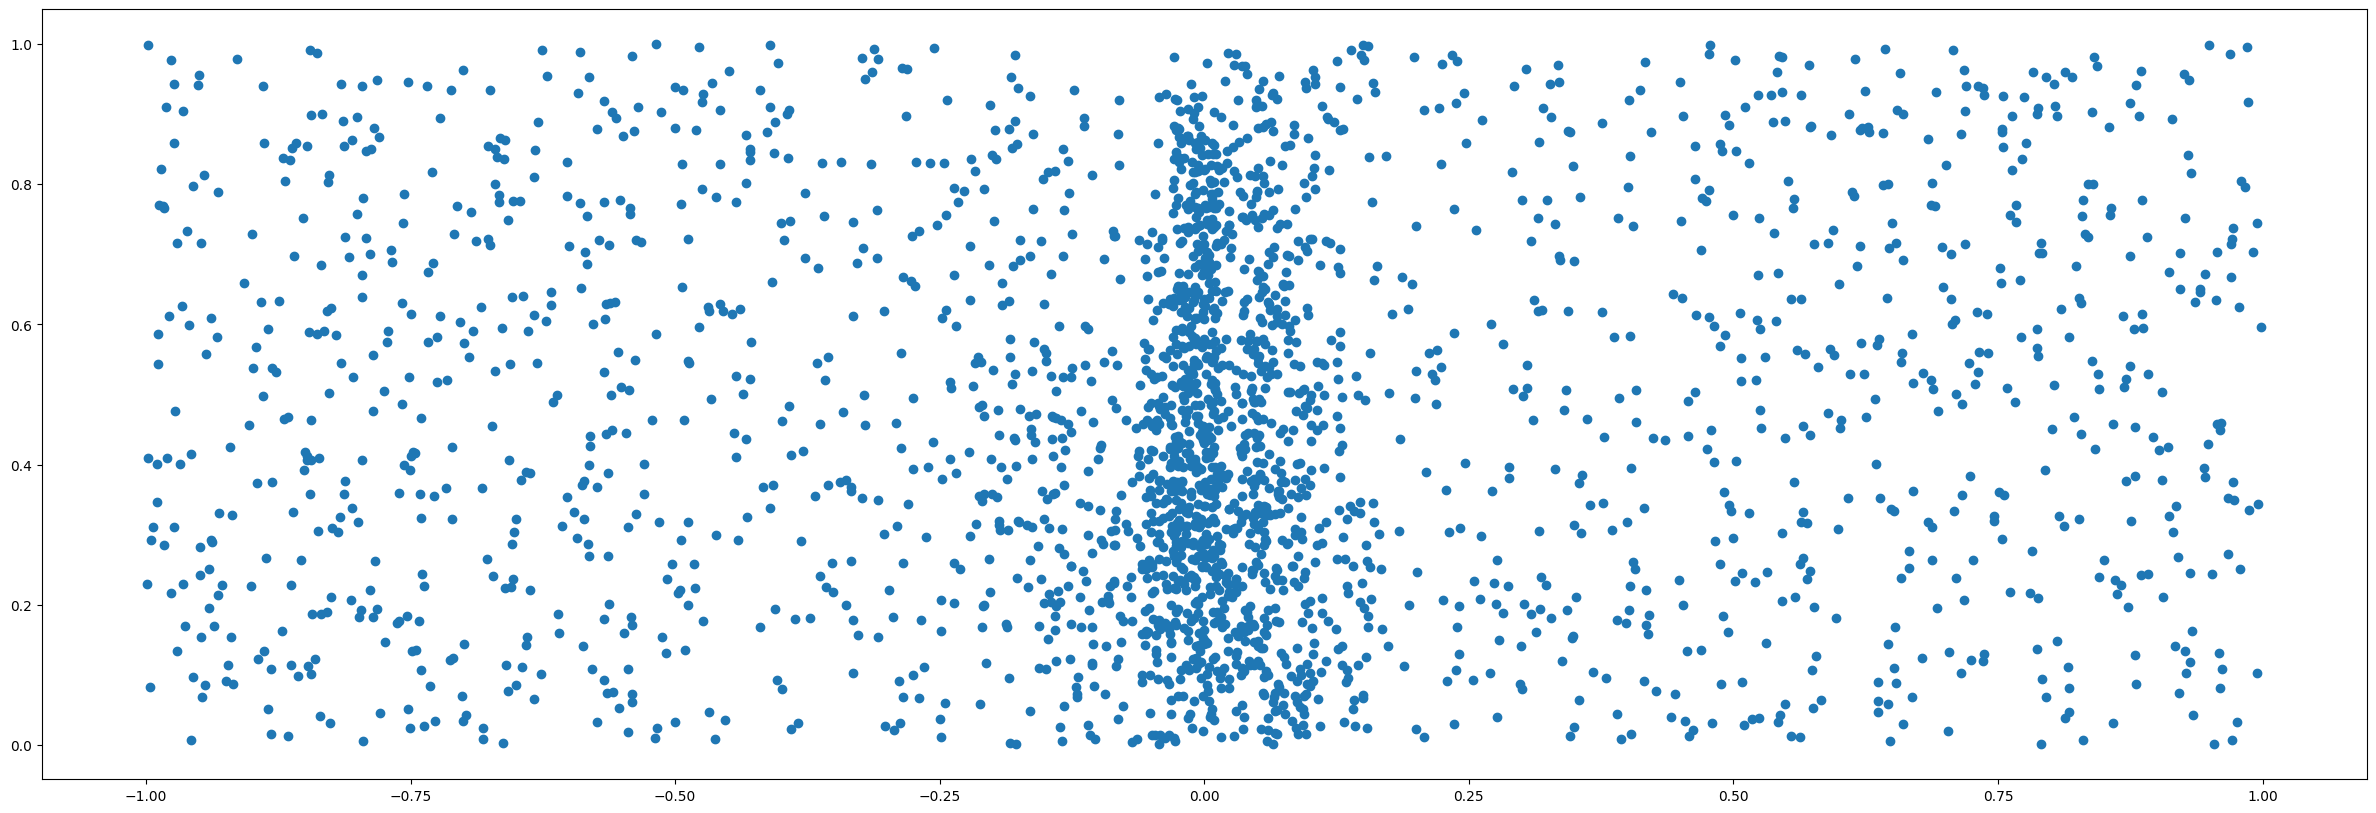

In [46]:
print(pinn.data["domain_data"].shape)

x = pinn.data["domain_data"].detach().cpu().numpy()[:, 0].flatten()
t = pinn.data["domain_data"].detach().cpu().numpy()[:, 1].flatten()

plt.figure(figsize=(30, 10))
plt.scatter(x, t)
plt.show()

In [47]:
pinn.train(iterations, patience, print_every, num_epochs_adam, num_epochs_lbfgs)

PINN: 100 iterations
a. PINN: 1000 epochs --> Adam
b. PINN: 1 epochs --> L-BFGS


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 1 | loss: 2.80e-05 | test_mae: 5.32e-03 - *Checkpoint*
Iteration: 2 | loss: 2.51e-05 | test_mae: 4.43e-03 - *Checkpoint*
Iteration: 3 | loss: 3.04e-05 | test_mae: 3.91e-03 - *Checkpoint*
Iteration: 4 | loss: 1.26e-05 | test_mae: 4.86e-03
Iteration: 5 | loss: 2.59e-05 | test_mae: 3.38e-03 - *Checkpoint*
Iteration: 6 | loss: 2.72e-05 | test_mae: 3.59e-03
Iteration: 7 | loss: 9.02e-04 | test_mae: 3.13e-03 - *Checkpoint*
Iteration: 8 | loss: 3.47e-05 | test_mae: 3.06e-03 - *Checkpoint*
Iteration: 9 | loss: 1.38e-05 | test_mae: 3.10e-03
Iteration: 10 | loss: 1.61e-05 | test_mae: 2.69e-03 - *Checkpoint*
Iteration: 11 | loss: 1.74e-05 | test_mae: 2.68e-03 - *Checkpoint*
Iteration: 12 | loss: 3.41e-04 | test_mae: 2.43e-03 - *Checkpoint*
Iteration: 13 | loss: 1.15e-05 | test_mae: 2.55e-03
Iteration: 14 | loss: 1.19e-05 | test_mae: 2.46e-03
Iteration: 15 | loss: 1.30e-05 | test_mae: 2.56e-03
Iteration: 16 | loss: 1.31e-05 | test_mae: 2.42e-03 - *Checkpoint*
Iteration: 17 | loss: 2.58e

In [48]:
pinn.train(iterations, patience, print_every, num_epochs_adam, num_epochs_lbfgs)

PINN: 100 iterations
a. PINN: 1000 epochs --> Adam
b. PINN: 1 epochs --> L-BFGS


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 1 | loss: 1.37e-05 | test_mae: 2.33e-03 - *Checkpoint*
Iteration: 2 | loss: 2.11e-05 | test_mae: 6.18e-03
Iteration: 3 | loss: 9.73e-05 | test_mae: 2.06e-03 - *Checkpoint*
Iteration: 4 | loss: 1.00e-04 | test_mae: 2.56e-03
Iteration: 5 | loss: 6.64e-04 | test_mae: 2.58e-03
Iteration: 6 | loss: 3.61e-05 | test_mae: 2.32e-03
Iteration: 7 | loss: 1.66e-04 | test_mae: 4.29e-03
Iteration: 8 | loss: 8.85e-05 | test_mae: 2.16e-03
Iteration: 9 | loss: 3.68e-04 | test_mae: 2.38e-03
Iteration: 10 | loss: 4.10e-05 | test_mae: 2.43e-03
Iteration: 11 | loss: 1.93e-04 | test_mae: 2.74e-03
Iteration: 12 | loss: 6.07e-05 | test_mae: 2.62e-03
Iteration: 13 | loss: 1.26e-02 | test_mae: 2.97e-03
Iteration: 14 | loss: 4.46e-04 | test_mae: 2.58e-03
Iteration: 15 | loss: 4.47e-05 | test_mae: 2.68e-03
Iteration: 16 | loss: 5.53e-05 | test_mae: 2.69e-03
Iteration: 17 | loss: 7.19e-05 | test_mae: 2.77e-03
Iteration: 18 | loss: 6.34e-05 | test_mae: 2.92e-03
Iteration: 19 | loss: 1.10e-04 | test_mae: 

ValueError: cannot convert float NaN to integer